In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math

import numpy as np

%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
path='./CIFAR_data'
train_data = datasets.CIFAR10(path, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(path, train=False, download=True, transform=transforms.ToTensor())

Extracting ./CIFAR_data/cifar-10-python.tar.gz to ./CIFAR_data
Files already downloaded and verified


In [5]:
mean = round(np.mean([train_data[i][0].numpy() for i in range(train_data.data.shape[0])]), 4)
std = round(np.std([train_data[i][0].numpy() for i in range(train_data.data.shape[0])]), 4)

print(mean, std)

0.4734 0.2516


In [6]:
transform = transforms.Compose([ transforms.ToTensor(),
                                      transforms.Normalize((mean,), (std,))])

def cifar(batch_size=50, valid=0, shuffle=True, transform=transform, path='./CIFAR_data'):
    test_data = datasets.CIFAR10(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.CIFAR10(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [7]:
train_loader, test_loader = cifar(batch_size=200, valid=0, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Data from https://pytorch.org/docs/stable/optim.html:
- torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
<br>optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
- torch.optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
- torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
- torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

https://medium.com/konvergen/modifying-adam-to-use-nesterov-accelerated-gradients-nesterov-accelerated-adaptive-moment-67154177e1fd
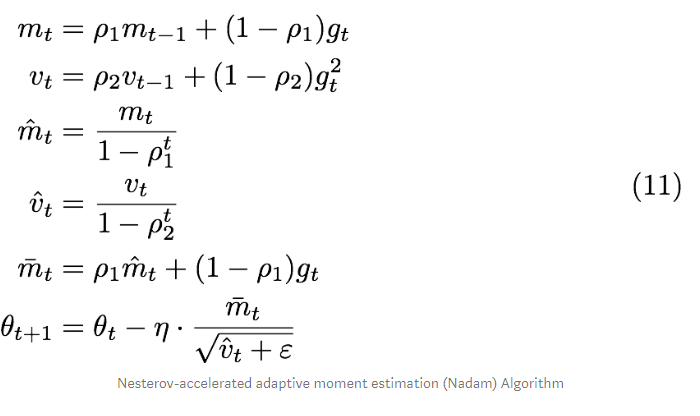

In [67]:
class MyOptim(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 rho=0.9, weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= rho:
            raise ValueError("Invalid rho value: {}".format(rho))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, rho=rho, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(MyOptim, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(MyOptim, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('MyOptim does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['acc_delta'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq, acc_delta = state['exp_avg'], state['exp_avg_sq'], state['acc_delta']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
                rho, eps = group['rho'], group['eps']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)
                
                delta = acc_delta.add(eps).sqrt_().div_(denom).mul_(exp_avg)
                
                p.data.add_(-group['lr'], delta)
                
                acc_delta.mul_(rho).addcmul_(1 - rho, delta, delta)

        return loss

In [68]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'MyOptim':
            self.optim = MyOptim(self.parameters(), **optim_params)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [10]:
models = {'SGD': Net(False, False, 'SGD', lr=1e-3),
          'momentum': Net(False, False, 'SGD', lr=1e-3, momentum=0.9),
          'Adadelta': Net(False, False, 'Adadelta', lr=1.),
          'RMSProp': Net(False, False, 'RMSProp', lr=1e-2),
          'Adam': Net(False, False, 'Adam', lr=1e-3), 
         }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [69]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}]\t'.format(epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}]\t'.format(epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [70]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [13]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/50000]	SGD: 2.3022 momentum: 2.3064 Adadelta: 2.3023 RMSProp: 2.2997 Adam: 2.3060
Train Epoch: 1 [30000/50000]	SGD: 2.3003 momentum: 2.3028 Adadelta: 2.0956 RMSProp: 2.2984 Adam: 1.7372
Train Epoch: 1 [50000/50000]	SGD: 2.2983 momentum: 2.3034 Adadelta: 1.9703 RMSProp: 2.2930 Adam: 1.5456
Test set:
SGD: Loss: 2.3034	Accuracy: 965.0/10000 (10%)
momentum: Loss: 2.3031	Accuracy: 999.0/10000 (10%)
Adadelta: Loss: 1.9080	Accuracy: 3133.0/10000 (31%)
RMSProp: Loss: 2.2820	Accuracy: 1099.0/10000 (11%)
Adam: Loss: 1.6343	Accuracy: 3985.0/10000 (40%)

Train Epoch: 2 [00000/50000]	SGD: 2.3034 momentum: 2.3014 Adadelta: 1.8154 RMSProp: 2.2698 Adam: 1.4997
Train Epoch: 2 [30000/50000]	SGD: 2.3025 momentum: 2.3019 Adadelta: 1.6242 RMSProp: 1.9380 Adam: 1.5102
Train Epoch: 2 [50000/50000]	SGD: 2.3024 momentum: 2.3067 Adadelta: 1.5329 RMSProp: 1.9088 Adam: 1.5975
Test set:
SGD: Loss: 2.3032	Accuracy: 972.0/10000 (10%)
momentum: Loss: 2.3026	Accuracy: 1017.0/10000 (10%)
Adadelta:

Train Epoch: 15 [50000/50000]	SGD: 2.2992 momentum: 1.9380 Adadelta: 0.8666 RMSProp: 1.6214 Adam: 1.0127
Test set:
SGD: Loss: 2.3005	Accuracy: 1189.0/10000 (12%)
momentum: Loss: 1.9193	Accuracy: 3023.0/10000 (30%)
Adadelta: Loss: 1.1745	Accuracy: 6018.0/10000 (60%)
RMSProp: Loss: 1.6115	Accuracy: 4343.0/10000 (43%)
Adam: Loss: 1.1439	Accuracy: 5932.0/10000 (59%)

Train Epoch: 16 [00000/50000]	SGD: 2.3002 momentum: 1.8271 Adadelta: 0.8120 RMSProp: 1.4097 Adam: 1.0209
Train Epoch: 16 [30000/50000]	SGD: 2.3008 momentum: 1.8094 Adadelta: 0.7723 RMSProp: 1.4899 Adam: 0.8982
Train Epoch: 16 [50000/50000]	SGD: 2.2978 momentum: 1.8614 Adadelta: 0.8310 RMSProp: 1.5172 Adam: 0.9987
Test set:
SGD: Loss: 2.3003	Accuracy: 1172.0/10000 (12%)
momentum: Loss: 1.8868	Accuracy: 3231.0/10000 (32%)
Adadelta: Loss: 1.2142	Accuracy: 5932.0/10000 (59%)
RMSProp: Loss: 1.4962	Accuracy: 4747.0/10000 (47%)
Adam: Loss: 1.1429	Accuracy: 5959.0/10000 (60%)

Train Epoch: 17 [00000/50000]	SGD: 2.3031 momentum: 1.8419

In [71]:
models = {'MyOptim': Net(False, False, 'MyOptim', lr=1e-3, rho=0.9)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [72]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/50000]	MyOptim: 2.3034
Train Epoch: 1 [30000/50000]	MyOptim: 2.3113
Train Epoch: 1 [50000/50000]	MyOptim: 2.3025
Test set:
MyOptim: Loss: 2.3065	Accuracy: 998.0/10000 (10%)

Train Epoch: 2 [00000/50000]	MyOptim: 2.2992
Train Epoch: 2 [30000/50000]	MyOptim: 2.3013
Train Epoch: 2 [50000/50000]	MyOptim: 2.2952
Test set:
MyOptim: Loss: 2.3063	Accuracy: 997.0/10000 (10%)

Train Epoch: 3 [00000/50000]	MyOptim: 2.3119
Train Epoch: 3 [30000/50000]	MyOptim: 2.2951
Train Epoch: 3 [50000/50000]	MyOptim: 2.3073
Test set:
MyOptim: Loss: 2.3062	Accuracy: 997.0/10000 (10%)

Train Epoch: 4 [00000/50000]	MyOptim: 2.2999
Train Epoch: 4 [30000/50000]	MyOptim: 2.2972
Train Epoch: 4 [50000/50000]	MyOptim: 2.2999
Test set:
MyOptim: Loss: 2.3061	Accuracy: 997.0/10000 (10%)

Train Epoch: 5 [00000/50000]	MyOptim: 2.3014
Train Epoch: 5 [30000/50000]	MyOptim: 2.3073
Train Epoch: 5 [50000/50000]	MyOptim: 2.3029
Test set:
MyOptim: Loss: 2.3059	Accuracy: 997.0/10000 (10%)

Train Epoch: 6 [0000

In [31]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.ylim((1.1, 2.4))
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim((0.05, 0.7))
        plt.legend(handles=handlers)
        plt.show()

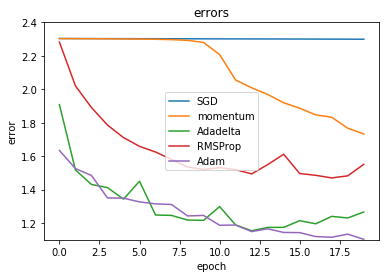

In [32]:
plot_graphs(test_log, 'loss')

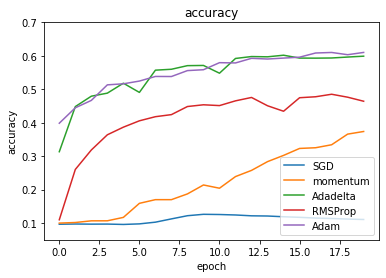

In [33]:
plot_graphs(test_log, 'accuracy')

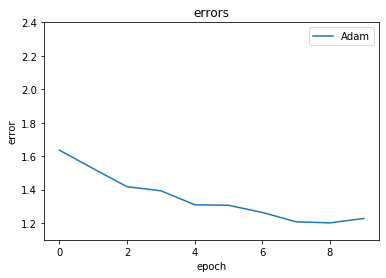

In [59]:
plot_graphs(test_log, 'loss')

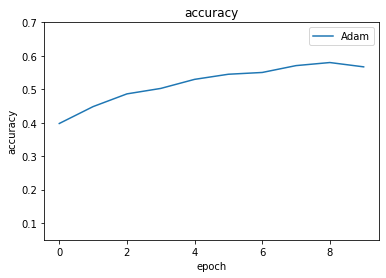

In [60]:
plot_graphs(test_log, 'accuracy')

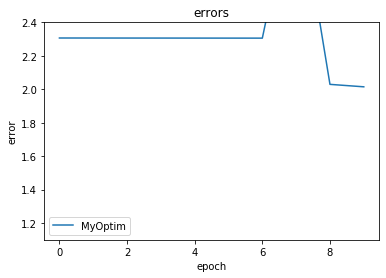

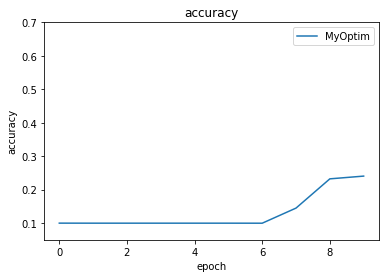

In [73]:
plot_graphs(test_log, 'loss')
plot_graphs(test_log, 'accuracy')